Установка библиоотек

In [59]:
!pip install ultralytics

In [60]:
import torch
import tqdm
import torchvision
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.models as models
import seaborn as sns
# import segmentation_models_pytorch as smp
from torch.nn.init import trunc_normal_
from sklearn.metrics import f1_score
from torch.nn import TransformerEncoder, TransformerEncoderLayer
from torchvision.models.vision_transformer import VisionTransformer
from torchvision import transforms
from PIL import Image
from torch.utils.data import Dataset, DataLoader, random_split
from pathlib import Path
from ultralytics import YOLO

Выбор датасета с танками

In [61]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("mahdifaour/tanks-dataset")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/tanks-dataset


In [62]:
class TanksDataset(Dataset):
    def __init__(self, images_dir: str, labels_dir: str, img_size: tuple = (224, 224)):
        self.img_size = img_size
        self.images = list(Path(images_dir).glob("*"))
        self.labels = list(Path(labels_dir).glob("*"))

        self.valid_pairs = []
        for img_path in self.images:
            label_path = Path(labels_dir) / f"{img_path.stem}.txt"
            if label_path.exists() and img_path.suffix.lower() in ['.jpg', '.jpeg', '.png']:
                self.valid_pairs.append((img_path, label_path))

        self.transform = transforms.Compose([
            transforms.Resize(img_size),
            transforms.ToTensor(),
        ])

    def __len__(self) -> int:
        return len(self.valid_pairs)

    def __getitem__(self, idx: int) -> tuple:
        img_path, label_path = self.valid_pairs[idx]
        image = Image.open(img_path).convert("RGB")
        original_width, original_height = image.size
        image = self.transform(image)
        new_height, new_width = image.shape[1], image.shape[2]
        boxes = []
        with open(label_path, 'r') as f:
            for line in f:
                class_id, xc, yc, w, h = line.strip().split()
                xc, yc, w, h = map(float, [xc, yc, w, h])
                class_id = int(class_id)
                xc_abs = xc * original_width
                yc_abs = yc * original_height
                w_abs = w * original_width
                h_abs = h * original_height

                x_min = (xc_abs - w_abs/2) * (new_width/original_width)
                y_min = (yc_abs - h_abs/2) * (new_height/original_height)
                x_max = (xc_abs + w_abs/2) * (new_width/original_width)
                y_max = (yc_abs + h_abs/2) * (new_height/original_height)

                boxes.append([x_min, y_min, x_max, y_max, class_id])
        return image, torch.tensor(boxes) if boxes else torch.zeros((0, 5))

Парсинг датасета

In [63]:
# from pathlib import Path
# root = Path(path)

# for p in root.rglob('*'):
#     print(p)

dataset_dir = f"{path}/tanks_dataset"
dataset = TanksDataset(dataset_dir + "/images/train", dataset_dir + "/labels/train")
trainset, testset = random_split(dataset, [0.8, 0.2])
print(len(trainset), len(testset))

102 25


Функция для того, чтобы разное количество bounding boxes танков было валидным для pytorch

In [64]:
def collate_fn(batch):
    images = []
    targets = []
    max_boxes = max(len(item[1]) for item in batch)  # Находим максимальное количество боксов

    for img, boxes in batch:
        images.append(img)

        # Дополняем нулями до максимального количества
        if len(boxes) < max_boxes:
            padding = torch.zeros((max_boxes - len(boxes), 5), dtype=boxes.dtype)
            boxes = torch.cat([boxes, padding])

        targets.append(boxes)

    return torch.stack(images), torch.stack(targets)

Создание Dataloaders

In [ ]:
batch_size = 8
trainloader = DataLoader(trainset, batch_size=batch_size, shuffle=True, collate_fn=collate_fn)
testloader = DataLoader(testset, batch_size=batch_size, collate_fn=collate_fn)

Демонстрация датасета

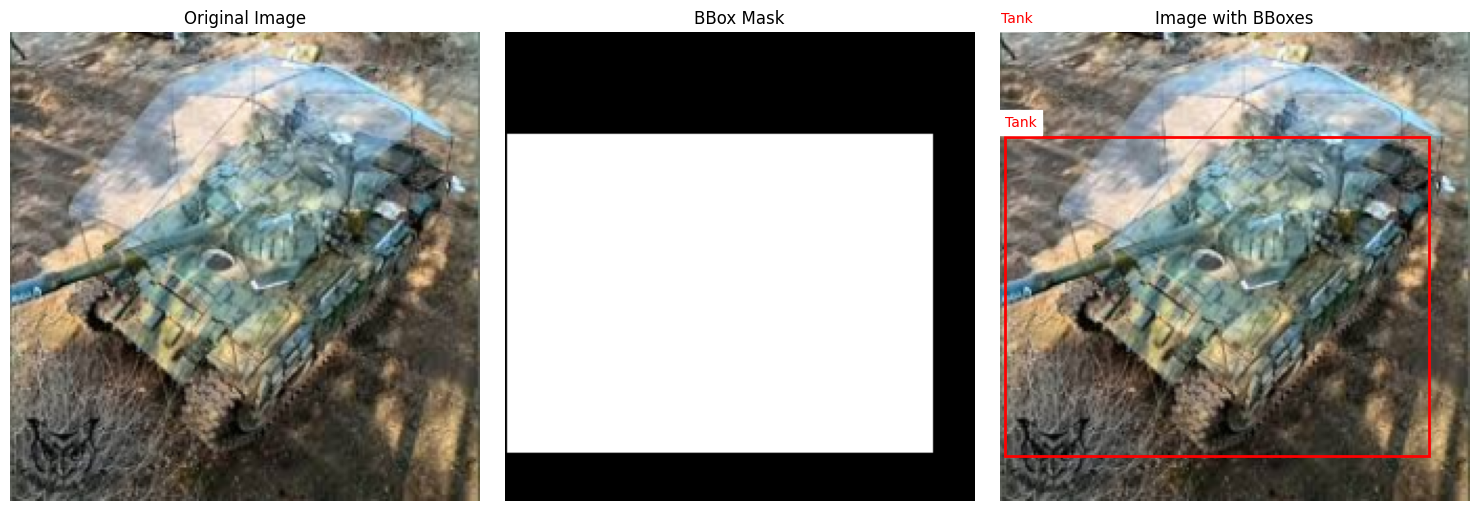

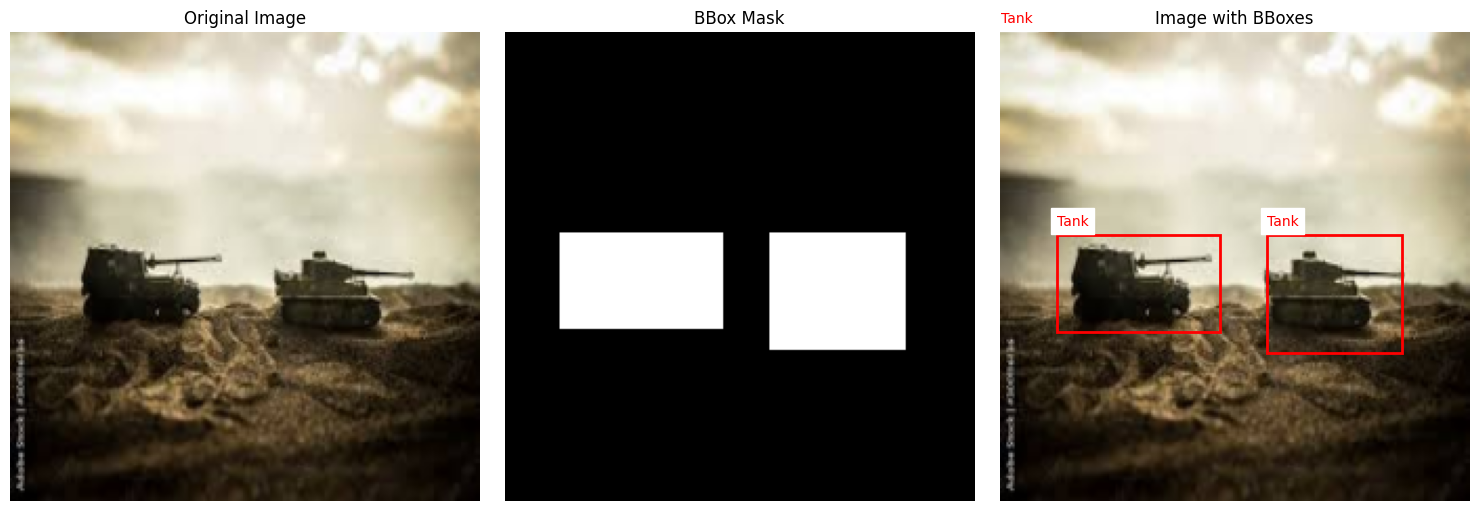

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np

def imshow(img, boxes, class_names=('Tank',)):
    npimg = img.numpy().transpose((1, 2, 0))
    npimg = np.clip(npimg, 0, 1)  # Для нормализованных изображений

    # Создаем маску для боксов
    mask = np.zeros(npimg.shape[:2])
    for box in boxes:
        if len(box) == 0:
            continue
        xmin, ymin, xmax, ymax, _ = box
        mask[int(ymin):int(ymax), int(xmin):int(xmax)] = 1

    fig, axes = plt.subplots(1, 3, figsize=(15, 5))

    # Оригинальное изображение
    axes[0].imshow(npimg)
    axes[0].axis('off')
    axes[0].set_title('Original Image')

    # Маска с боксами
    axes[1].imshow(mask, cmap='gray', vmin=0, vmax=1)
    axes[1].axis('off')
    axes[1].set_title('BBox Mask')

    # Наложение боксов на изображение
    axes[2].imshow(npimg)
    for box in boxes:
        if len(box) == 0:
            continue
        xmin, ymin, xmax, ymax, class_id = box
        rect = patches.Rectangle(
            (xmin, ymin),
            xmax - xmin,
            ymax - ymin,
            linewidth=2,
            edgecolor='red',
            facecolor='none'
        )
        axes[2].add_patch(rect)
        axes[2].text(
            xmin,
            ymin - 5,
            class_names[int(class_id)],
            color='red',
            fontsize=10,
            backgroundcolor='white'
        )
    axes[2].axis('off')
    axes[2].set_title('Image with BBoxes')

    plt.tight_layout()
    plt.show()

# Пример использования
dataiter = iter(trainloader)
images, boxes = next(dataiter)

n_show = 2
for img, bboxes in zip(images[:n_show], boxes[:n_show]):
    imshow(img, bboxes)

In [67]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


Получаем yaml config YOLO для датасета

In [ ]:
import yaml
import os

def create_config():
    config_data = {
        "path": f"{dataset_dir}/",
        "train": "images/train",
        "val": "images/val",
        "names": {0: "Tank"}
    }
    config_path = "dataset_config.yaml"
    with open(config_path, "w") as f:
        yaml.dump(config_data, f, sort_keys=False)

    return os.path.abspath(config_path)

Обучение YOLO

In [ ]:
def train_yolo(model_cfg='yolov8n.yaml',
               data_cfg='tanks.yaml',
               epochs=50,
               imgsz=640,
               batch=8,
               device='cuda'):
    model = YOLO(model_cfg).to(device)

    config = {
        'data': data_cfg,
        'epochs': epochs,
        'imgsz': imgsz,
        'batch': batch,
        'device': device,
        'plots': False,
        'save_json': True,
        'exist_ok': True
    }
    results = model.train(**config)
    return model, results

def calculate_mIoU(model, dataloader, device='cuda'):
    model.eval()
    total_iou = 0.0
    total_samples = 0

    with torch.no_grad():
        for batch in dataloader:
            images = batch[0].to(device)
            results = model(images)

            for result, targets in zip(results, batch[1]):
                pred_boxes = result.boxes.xyxy.cpu()
                true_boxes = targets[:, 1:5].cpu()

                if len(pred_boxes) == 0 or len(true_boxes) == 0:
                    continue

                iou = torchvision.ops.box_iou(pred_boxes, true_boxes)
                best_iou = torch.diag(iou).mean()
                total_iou += best_iou.item()
                total_samples += 1

    return total_iou / total_samples if total_samples > 0 else 0.0


In [70]:
model, results = train_yolo(
        model_cfg='yolov8n.yaml',
        data_cfg=str(create_config()),
        epochs=100,
        device=device
)

engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=8, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/content/dataset_config.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=100, erasing=0.4, exist_ok=True, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8n.yaml, momentum=0.937, mosaic=1.0, multi_scale=False, name=train, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True, patience=100, perspective=0.0, plots=False, pose=12.0, pretrained=True, profile=False, project=None, rect=False, resume=False, retina_masks=False,

train: Scanning /kaggle/input/tanks-dataset/tanks_dataset/labels/train... 127 images, 3 backgrounds, 0 corrupt: 100%|██████████| 130/130 [00:00<00:00, 471.20it/s]

WARNING ⚠️ train: Cache directory /kaggle/input/tanks-dataset/tanks_dataset/labels is not writeable, cache not saved.
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 20.4±1.7 MB/s, size: 10.2 KB)


val: Scanning /kaggle/input/tanks-dataset/tanks_dataset/labels/val... 15 images, 0 backgrounds, 0 corrupt: 100%|██████████| 15/15 [00:00<00:00, 257.84it/s]

WARNING ⚠️ val: Cache directory /kaggle/input/tanks-dataset/tanks_dataset/labels is not writeable, cache not saved.


optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.002, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 2 dataloader workers
Logging results to runs/detect/train
Starting training for 100 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      1/100      1.51G      3.152      3.727      4.258         11        640: 100%|██████████| 17/17 [00:06<00:00,  2.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.40it/s]

                   all         15         16    0.00355      0.938     0.0255     0.0166



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      2/100      1.56G       3.15      3.677      4.223          3        640: 100%|██████████| 17/17 [00:04<00:00,  3.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.39it/s]

                   all         15         16    0.00348      0.938     0.0271    0.00936



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      3/100      1.56G      3.198      3.462       4.11          5        640: 100%|██████████| 17/17 [00:04<00:00,  3.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.70it/s]

                   all         15         16    0.00347      0.938     0.0479     0.0169



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      4/100      1.56G       3.07      3.568      3.989          4        640: 100%|██████████| 17/17 [00:02<00:00,  6.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.20it/s]

                   all         15         16    0.00358      0.938     0.0706     0.0263



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      5/100      1.56G      2.992      3.288      3.828          7        640: 100%|██████████| 17/17 [00:02<00:00,  7.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.77it/s]

                   all         15         16     0.0043      0.938     0.0507     0.0148



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      6/100      1.56G      2.921      3.297      3.681          3        640: 100%|██████████| 17/17 [00:02<00:00,  6.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.53it/s]

                   all         15         16    0.00968      0.938      0.321     0.0972



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      7/100      1.56G      2.911      3.223      3.607          7        640: 100%|██████████| 17/17 [00:02<00:00,  5.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.48it/s]

                   all         15         16    0.00333      0.938      0.197     0.0459



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      8/100      1.56G      2.907      3.241      3.495          5        640: 100%|██████████| 17/17 [00:02<00:00,  6.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.92it/s]

                   all         15         16    0.00416      0.875      0.165     0.0413



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      9/100      1.56G      2.736      3.069      3.375          6        640: 100%|██████████| 17/17 [00:04<00:00,  4.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.74it/s]

                   all         15         16      0.168      0.125      0.129     0.0373



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     10/100      1.56G      2.812      3.096      3.371          2        640: 100%|██████████| 17/17 [00:05<00:00,  2.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.88it/s]

                   all         15         16     0.0114      0.688     0.0127    0.00397



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     11/100      1.56G      2.783      3.021      3.296          5        640: 100%|██████████| 17/17 [00:02<00:00,  6.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.45it/s]

                   all         15         16       0.05      0.375     0.0453     0.0106



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     12/100      1.56G      2.723       2.91        3.2          8        640: 100%|██████████| 17/17 [00:02<00:00,  7.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.60it/s]

                   all         15         16     0.0606        0.5     0.0576     0.0105



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     13/100      1.56G      2.589      2.859      3.116          2        640: 100%|██████████| 17/17 [00:02<00:00,  5.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.54it/s]

                   all         15         16      0.141      0.188      0.138     0.0325



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     14/100      1.56G      2.696      2.885      3.217          5        640: 100%|██████████| 17/17 [00:02<00:00,  6.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.49it/s]

                   all         15         16     0.0149          1     0.0273    0.00678



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     15/100      1.56G      2.719      2.743      3.206          7        640: 100%|██████████| 17/17 [00:02<00:00,  7.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.62it/s]

                   all         15         16     0.0622       0.75      0.151     0.0737



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     16/100      1.57G      2.681      2.772      3.149          6        640: 100%|██████████| 17/17 [00:02<00:00,  7.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.84it/s]


                   all         15         16     0.0813     0.0625     0.0411     0.0116

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     17/100      1.58G      2.656      2.775      3.215          4        640: 100%|██████████| 17/17 [00:02<00:00,  6.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.15it/s]

                   all         15         16      0.176      0.375      0.244     0.0479



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     18/100       1.6G      2.504      2.661      3.097          9        640: 100%|██████████| 17/17 [00:03<00:00,  5.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.54it/s]

                   all         15         16      0.376      0.625      0.432     0.0955



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     19/100      1.62G      2.613      2.697      3.093          4        640: 100%|██████████| 17/17 [00:02<00:00,  6.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.27it/s]

                   all         15         16      0.445        0.5      0.582      0.172



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     20/100      1.62G      2.599      2.649      3.078          5        640: 100%|██████████| 17/17 [00:02<00:00,  7.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.84it/s]

                   all         15         16      0.548      0.938       0.68      0.237



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     21/100      1.65G      2.463      2.625      3.011          6        640: 100%|██████████| 17/17 [00:02<00:00,  7.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.89it/s]


                   all         15         16      0.589      0.875      0.713      0.241

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     22/100      1.67G      2.509      2.585      3.037          4        640: 100%|██████████| 17/17 [00:03<00:00,  4.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.02it/s]

                   all         15         16      0.512       0.75      0.547      0.193



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     23/100      1.69G       2.46      2.587       2.99          8        640: 100%|██████████| 17/17 [00:03<00:00,  4.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.04it/s]

                   all         15         16      0.346       0.25      0.243     0.0779



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     24/100       1.7G      2.436      2.595      3.008          5        640: 100%|██████████| 17/17 [00:02<00:00,  7.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.62it/s]

                   all         15         16      0.441        0.5      0.483      0.178



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     25/100      1.72G      2.471      2.538      3.002         11        640: 100%|██████████| 17/17 [00:04<00:00,  4.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.02it/s]

                   all         15         16      0.478      0.562      0.578      0.209



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     26/100      1.74G       2.45       2.49      2.997          3        640: 100%|██████████| 17/17 [00:02<00:00,  6.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.11it/s]

                   all         15         16      0.553      0.562       0.61      0.244



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     27/100      1.76G      2.392      2.526      2.902         11        640: 100%|██████████| 17/17 [00:02<00:00,  7.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.17it/s]

                   all         15         16      0.446      0.812      0.554      0.239



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     28/100      1.76G      2.377      2.485      2.961          5        640: 100%|██████████| 17/17 [00:02<00:00,  7.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.77it/s]

                   all         15         16       0.12      0.154        0.2      0.082



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     29/100      1.79G      2.357      2.441      2.949          5        640: 100%|██████████| 17/17 [00:02<00:00,  6.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.36it/s]

                   all         15         16      0.546      0.562      0.629      0.258



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     30/100      1.81G      2.397      2.465      2.956          5        640: 100%|██████████| 17/17 [00:03<00:00,  5.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.96it/s]

                   all         15         16       0.28       0.75      0.419      0.129



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     31/100      1.82G      2.318      2.397      2.921         11        640: 100%|██████████| 17/17 [00:02<00:00,  7.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.68it/s]

                   all         15         16      0.358       0.75      0.577      0.207



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     32/100      1.84G      2.326      2.404      2.859          9        640: 100%|██████████| 17/17 [00:02<00:00,  7.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.17it/s]

                   all         15         16      0.173        0.5      0.176     0.0506



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     33/100      1.86G      2.321       2.34      2.831          8        640: 100%|██████████| 17/17 [00:02<00:00,  7.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.21it/s]

                   all         15         16      0.182        0.5       0.19     0.0532



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     34/100      1.88G       2.38      2.446      2.917         13        640: 100%|██████████| 17/17 [00:03<00:00,  4.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.19it/s]

                   all         15         16      0.458        0.5      0.474      0.149



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     35/100      1.89G      2.233      2.434      2.882          7        640: 100%|██████████| 17/17 [00:02<00:00,  6.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.93it/s]


                   all         15         16      0.455      0.312      0.404      0.121

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     36/100       1.9G      2.274      2.295      2.828          3        640: 100%|██████████| 17/17 [00:02<00:00,  7.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.97it/s]

                   all         15         16       0.26      0.264      0.354      0.147



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     37/100      1.93G      2.317      2.424      2.885          4        640: 100%|██████████| 17/17 [00:02<00:00,  7.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.44it/s]

                   all         15         16      0.566       0.75      0.619      0.262



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     38/100      1.94G      2.337      2.332      2.849          4        640: 100%|██████████| 17/17 [00:03<00:00,  5.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.82it/s]

                   all         15         16      0.694      0.562      0.646      0.284



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     39/100      1.96G      2.208       2.38      2.847          3        640: 100%|██████████| 17/17 [00:02<00:00,  7.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.32it/s]

                   all         15         16      0.349      0.375      0.378      0.199



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     40/100      1.98G       2.25      2.323      2.815         11        640: 100%|██████████| 17/17 [00:02<00:00,  7.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.17it/s]

                   all         15         16      0.445      0.501      0.451      0.201



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     41/100      1.99G      2.223      2.295      2.795          6        640: 100%|██████████| 17/17 [00:02<00:00,  6.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.61it/s]

                   all         15         16      0.348      0.562      0.403      0.136



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     42/100      2.01G      2.213      2.265      2.798          9        640: 100%|██████████| 17/17 [00:03<00:00,  4.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.12it/s]

                   all         15         16      0.413      0.688      0.595      0.238



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     43/100      2.03G      2.213       2.26      2.792          9        640: 100%|██████████| 17/17 [00:02<00:00,  7.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.83it/s]

                   all         15         16      0.619      0.711      0.751      0.394



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     44/100      2.04G      2.172      2.278      2.749          6        640: 100%|██████████| 17/17 [00:02<00:00,  7.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.19it/s]

                   all         15         16      0.524       0.75      0.727       0.35



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     45/100      2.06G      2.184      2.308      2.688          4        640: 100%|██████████| 17/17 [00:02<00:00,  6.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.12it/s]

                   all         15         16      0.643      0.562      0.609      0.273



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     46/100      2.08G      2.191      2.331      2.734          6        640: 100%|██████████| 17/17 [00:03<00:00,  5.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.38it/s]

                   all         15         16       0.59       0.75      0.713      0.269



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     47/100       2.1G       2.12      2.235      2.685         11        640: 100%|██████████| 17/17 [00:02<00:00,  6.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.87it/s]

                   all         15         16      0.664      0.863      0.853        0.4



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     48/100      2.11G      2.147      2.215      2.683          6        640: 100%|██████████| 17/17 [00:02<00:00,  7.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.89it/s]

                   all         15         16      0.643      0.812        0.8      0.361



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     49/100      2.13G      2.121      2.191      2.719          6        640: 100%|██████████| 17/17 [00:02<00:00,  7.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.42it/s]

                   all         15         16      0.319        0.5      0.418      0.112



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     50/100      2.15G       2.09      2.155      2.667          8        640: 100%|██████████| 17/17 [00:02<00:00,  6.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.23it/s]

                   all         15         16      0.506      0.512      0.654      0.278



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     51/100      2.16G      2.117      2.173      2.684          5        640: 100%|██████████| 17/17 [00:03<00:00,  5.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.69it/s]

                   all         15         16      0.524      0.414      0.455      0.227



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     52/100      2.17G       2.09      2.137       2.66          8        640: 100%|██████████| 17/17 [00:02<00:00,  7.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.11it/s]

                   all         15         16      0.499      0.875      0.738      0.359



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     53/100       2.2G      2.148      2.085      2.686          9        640: 100%|██████████| 17/17 [00:02<00:00,  6.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.92it/s]

                   all         15         16      0.781      0.625      0.804      0.356



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     54/100      2.22G      2.076      2.061      2.656          8        640: 100%|██████████| 17/17 [00:02<00:00,  7.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.44it/s]

                   all         15         16      0.465      0.562      0.605      0.256



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     55/100      2.23G      2.041      2.091      2.658          4        640: 100%|██████████| 17/17 [00:03<00:00,  4.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.19it/s]

                   all         15         16      0.545      0.562      0.524      0.198



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     56/100      2.25G      2.009      2.069      2.639          6        640: 100%|██████████| 17/17 [00:02<00:00,  7.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.94it/s]

                   all         15         16       0.41      0.562      0.569      0.217



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     57/100      2.27G      1.964      2.086      2.591          7        640: 100%|██████████| 17/17 [00:02<00:00,  7.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.79it/s]

                   all         15         16      0.546      0.688      0.691      0.297



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     58/100      2.28G      1.962       2.03      2.578          4        640: 100%|██████████| 17/17 [00:02<00:00,  7.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.27it/s]

                   all         15         16      0.645      0.625      0.759      0.392



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     59/100       2.3G      2.057      2.047      2.619          5        640: 100%|██████████| 17/17 [00:03<00:00,  5.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.95it/s]

                   all         15         16      0.523      0.755      0.774      0.421



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     60/100      2.31G       2.01      2.028      2.548          5        640: 100%|██████████| 17/17 [00:02<00:00,  6.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.65it/s]

                   all         15         16      0.476      0.875      0.698       0.37



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     61/100      2.34G      1.964      2.051      2.548          8        640: 100%|██████████| 17/17 [00:02<00:00,  5.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.36it/s]

                   all         15         16      0.625       0.75      0.781      0.415



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     62/100      2.35G      2.046      2.105      2.639          5        640: 100%|██████████| 17/17 [00:02<00:00,  7.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.11it/s]

                   all         15         16      0.775       0.75      0.776      0.411



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     63/100      2.37G      2.007      2.064      2.609          5        640: 100%|██████████| 17/17 [00:03<00:00,  5.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.71it/s]

                   all         15         16          1       0.36      0.493      0.285



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     64/100      2.39G      1.997      2.003       2.57         12        640: 100%|██████████| 17/17 [00:02<00:00,  6.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.62it/s]


                   all         15         16      0.833      0.375      0.453      0.238

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     65/100       2.4G      1.973      2.036      2.565          4        640: 100%|██████████| 17/17 [00:02<00:00,  7.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.11it/s]

                   all         15         16      0.977      0.438      0.698      0.355



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     66/100      2.42G      1.952      1.908      2.525          7        640: 100%|██████████| 17/17 [00:02<00:00,  7.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.78it/s]

                   all         15         16      0.898        0.5      0.698      0.321



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     67/100      2.44G      2.002      1.991      2.534          9        640: 100%|██████████| 17/17 [00:02<00:00,  6.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.36it/s]

                   all         15         16       0.57      0.746      0.718      0.288



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     68/100      2.45G      1.913      1.954      2.521          6        640: 100%|██████████| 17/17 [00:03<00:00,  5.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.51it/s]

                   all         15         16      0.714      0.781        0.8      0.428



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     69/100      2.47G       1.87      1.874      2.465          8        640: 100%|██████████| 17/17 [00:02<00:00,  7.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.38it/s]

                   all         15         16      0.538      0.875      0.777      0.396



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     70/100      2.49G      1.906      1.928      2.541          3        640: 100%|██████████| 17/17 [00:02<00:00,  6.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.97it/s]


                   all         15         16      0.654      0.688      0.789      0.407

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     71/100      2.51G      1.952      1.886      2.514          9        640: 100%|██████████| 17/17 [00:02<00:00,  7.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.77it/s]

                   all         15         16      0.673      0.812       0.82      0.386



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     72/100      2.52G      1.948      1.949      2.506          3        640: 100%|██████████| 17/17 [00:03<00:00,  4.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.62it/s]

                   all         15         16      0.835      0.625      0.789      0.357



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     73/100      2.54G       1.92      1.913      2.548          8        640: 100%|██████████| 17/17 [00:02<00:00,  6.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.25it/s]

                   all         15         16      0.704       0.75      0.771      0.345



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     74/100      2.56G      1.907      1.923      2.526         10        640: 100%|██████████| 17/17 [00:02<00:00,  6.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.11it/s]

                   all         15         16      0.398      0.688      0.445      0.172



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     75/100      2.57G      1.891      1.961      2.487          2        640: 100%|██████████| 17/17 [00:02<00:00,  6.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.88it/s]

                   all         15         16      0.711      0.625      0.612      0.271



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     76/100      2.58G      1.881      1.882      2.486         11        640: 100%|██████████| 17/17 [00:03<00:00,  4.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.55it/s]

                   all         15         16      0.875      0.625      0.716      0.354



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     77/100      2.61G       1.86      1.824      2.471          9        640: 100%|██████████| 17/17 [00:02<00:00,  7.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.50it/s]

                   all         15         16      0.791      0.562      0.681      0.341



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     78/100      2.63G      1.892      1.869      2.444          5        640: 100%|██████████| 17/17 [00:02<00:00,  6.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.59it/s]

                   all         15         16      0.687      0.812      0.804      0.427



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     79/100      2.64G      1.838      1.851      2.446          9        640: 100%|██████████| 17/17 [00:03<00:00,  5.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.12it/s]

                   all         15         16      0.806      0.812      0.834      0.438



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     80/100      2.66G      1.811      1.754      2.408          6        640: 100%|██████████| 17/17 [00:03<00:00,  4.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.30it/s]

                   all         15         16      0.801      0.756      0.866      0.421



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     81/100      2.68G      1.866      1.834      2.487          4        640: 100%|██████████| 17/17 [00:02<00:00,  6.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.99it/s]

                   all         15         16      0.841      0.661      0.837      0.418



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     82/100      2.69G      1.838      1.834      2.468          6        640: 100%|██████████| 17/17 [00:02<00:00,  7.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.97it/s]

                   all         15         16      0.913      0.658      0.811      0.403



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     83/100      2.71G      1.831      1.761      2.413          4        640: 100%|██████████| 17/17 [00:02<00:00,  6.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.49it/s]

                   all         15         16      0.657       0.72      0.776      0.372



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     84/100      2.72G      1.867      1.819      2.458          8        640: 100%|██████████| 17/17 [00:03<00:00,  4.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.30it/s]

                   all         15         16      0.678      0.789      0.823      0.389



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     85/100      2.75G       1.77      1.656      2.371          5        640: 100%|██████████| 17/17 [00:02<00:00,  6.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.24it/s]

                   all         15         16        0.6      0.812      0.804        0.4



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     86/100      2.76G      1.759      1.724      2.411          9        640: 100%|██████████| 17/17 [00:02<00:00,  7.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.27it/s]

                   all         15         16      0.732      0.688      0.811      0.397



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     87/100      2.78G      1.794      1.746      2.403          4        640: 100%|██████████| 17/17 [00:02<00:00,  7.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.95it/s]


                   all         15         16      0.697       0.75      0.802       0.43

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     88/100      2.79G      1.875      1.755      2.467          4        640: 100%|██████████| 17/17 [00:02<00:00,  6.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.64it/s]

                   all         15         16      0.813       0.75      0.815      0.425



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     89/100      2.81G       1.84      1.775       2.44          6        640: 100%|██████████| 17/17 [00:03<00:00,  5.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.70it/s]

                   all         15         16      0.704       0.75      0.789      0.425



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     90/100      2.83G      1.817      1.667      2.413          5        640: 100%|██████████| 17/17 [00:02<00:00,  7.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.80it/s]

                   all         15         16      0.674      0.812      0.784      0.419


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     91/100      2.85G      1.698      2.053       2.35          2        640: 100%|██████████| 17/17 [00:02<00:00,  5.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.18it/s]

                   all         15         16      0.737      0.812      0.793      0.406



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     92/100      2.85G      1.674      1.939      2.432          2        640: 100%|██████████| 17/17 [00:02<00:00,  6.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.97it/s]

                   all         15         16      0.785       0.75       0.81      0.413



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     93/100      2.88G      1.691      1.818       2.36          4        640: 100%|██████████| 17/17 [00:03<00:00,  5.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.47it/s]

                   all         15         16       0.88      0.688      0.844       0.42



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     94/100       2.9G      1.713      1.842      2.418          2        640: 100%|██████████| 17/17 [00:02<00:00,  7.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.93it/s]

                   all         15         16      0.898       0.75      0.838       0.44



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     95/100      2.92G      1.678      1.686      2.327          5        640: 100%|██████████| 17/17 [00:02<00:00,  7.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.46it/s]

                   all         15         16      0.922       0.74       0.83      0.454



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     96/100      2.93G      1.659      1.703      2.326          3        640: 100%|██████████| 17/17 [00:02<00:00,  7.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.41it/s]

                   all         15         16       0.88      0.688      0.829      0.453



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     97/100      2.95G      1.665      1.706      2.381          4        640: 100%|██████████| 17/17 [00:03<00:00,  4.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.53it/s]

                   all         15         16      0.752      0.625      0.698      0.404



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     98/100      2.97G       1.66      1.648      2.367          2        640: 100%|██████████| 17/17 [00:02<00:00,  7.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.08it/s]

                   all         15         16      0.695      0.712      0.692      0.396



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     99/100      2.98G      1.711      1.653      2.405          3        640: 100%|██████████| 17/17 [00:02<00:00,  7.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.22it/s]

                   all         15         16       0.77      0.562      0.689      0.392



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    100/100      2.99G      1.621      1.649      2.297          2        640: 100%|██████████| 17/17 [00:02<00:00,  7.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.51it/s]

                   all         15         16      0.633      0.688       0.69      0.386



100 epochs completed in 0.092 hours.
Optimizer stripped from runs/detect/train/weights/last.pt, 6.3MB
Optimizer stripped from runs/detect/train/weights/best.pt, 6.3MB

Validating runs/detect/train/weights/best.pt...
Ultralytics 8.3.130 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n summary (fused): 72 layers, 3,005,843 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.70it/s]

                   all         15         16      0.922      0.742       0.83      0.454
Speed: 0.2ms preprocess, 1.4ms inference, 0.0ms loss, 1.3ms postprocess per image
Saving runs/detect/train/predictions.json...
Results saved to runs/detect/train


Вывод метрик обученной модели

In [71]:
metrics = {
    'precision': results.results_dict['metrics/precision(B)'],
    'recall': results.results_dict['metrics/recall(B)'],
    'mAP50': results.results_dict['metrics/mAP50(B)'],
    'mAP50-95': results.results_dict['metrics/mAP50-95(B)']
}
for key, metric in metrics.items():
    print(f'{key}: {metric}')

precision: 0.9222388852018482
recall: 0.7418291307180196
mAP50: 0.829849804530298
mAP50-95: 0.45374129159392823
